In [64]:
import re
import pandas as pd
pd.set_option('display.max_colwidth', 200)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from yellowbrick.text.freqdist import FreqDistVisualizer 

%matplotlib inline

In [65]:
# dataset is taken from Kaggle website
df_train = pd.read_csv('./dataset/train.csv')

# Note: this df does not have the target column
df_test = pd.read_csv('./dataset/test.csv')

In [66]:
# train data
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [67]:
df_train.shape

(7613, 5)

In [68]:
# test data . Note: it does not have target column and just can be used for testing
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [69]:
print('missing values of the keyword column: {}/{} ({}%)'.
      format(df_train.keyword.isna().sum(),len(df_train),
             round((df_train.keyword.isna().sum() / len(df_train)) * 100,2)))

print('missing values of the location column: {}/{} ({}%)'.
      format(df_train.location.isna().sum(), len(df_train),
             round((df_train.location.isna().sum() / len(df_train)) * 100,2)))

missing values of the keyword column: 61/7613 (0.8%)
missing values of the location column: 2533/7613 (33.27%)


In [70]:
# the number of classes are almost balanced. So, we do not need to balance them.
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

we are going to drop the columns which have missing values as well as ID. 
ID does not add any value to the model that we are about to create.

In [71]:
df_train.drop(['id','location', 'keyword'], axis=1, inplace=True)

In [72]:
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [73]:
documents = list()

wnl = WordNetLemmatizer()

for i in range(0, len(df_train)):
    
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(df_train.loc[i,'text']))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to lowercase
    document = document.lower()
    
    # lemmatization and stemmer
    # In lemmatization, we can convert the word into the root form of the word. 
    # for exampel, "houses" is converted into "house".
    document = document.split()
    document = [ps.stem(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [74]:
len(documents)

7613

In [75]:
df_train[40:50]

,text,target
40,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
41,on the outside you're ablaze and alive\nbut you're dead inside,0
42,Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??,0
43,SOOOO PUMPED FOR ABLAZE ???? @southridgelife,0
44,I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX,0
45,I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6,0
46,How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr,1
47,Building the perfect tracklist to life leave the streets ablaze,0
48,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw,0
49,First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least.,0


In [76]:
# print 10 rows
documents[40:50]

['check these out http co roi2nsmejj http co 3tj8zjin21 http co yduixefip http co lxtjc87kl nsfw',
 'on the outsid you re ablaz and aliv but you re dead insid',
 'had an awesom time visit the cfc head offic the ancop site and ablaz thank to tita vida for take care of us',
 'soooo pump for ablaz southridgelif',
 'i want to set chicago ablaz with my preach but not my hotel http co o9qknbfofx',
 'i gain 3 follow in the last week you know your stat and grow with http co tiyulif5c6',
 'how the west wa burn thousand of wildfir ablaz in california alon http co vl5tbr3wbr',
 'build the perfect tracklist to life leav the street ablaz',
 'check these out http co roi2nsmejj http co 3tj8zjin21 http co yduixefip http co lxtjc87kl nsfw',
 'first night with retain in it quit weird better get use to it have to wear them everi singl night for the next year at least']

## Converting Text to Numbers

Machines cannot understand the raw text. Machines can only understand numbers. 
Statistical techniques including machine learning can only deal with numbers. 
Therefore, we need to convert our text into numbers.

<ul>   
   <li><b>max_features:</b> Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus</li>
    <li><b>max_df:</b> When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold.</li>
    </ul>

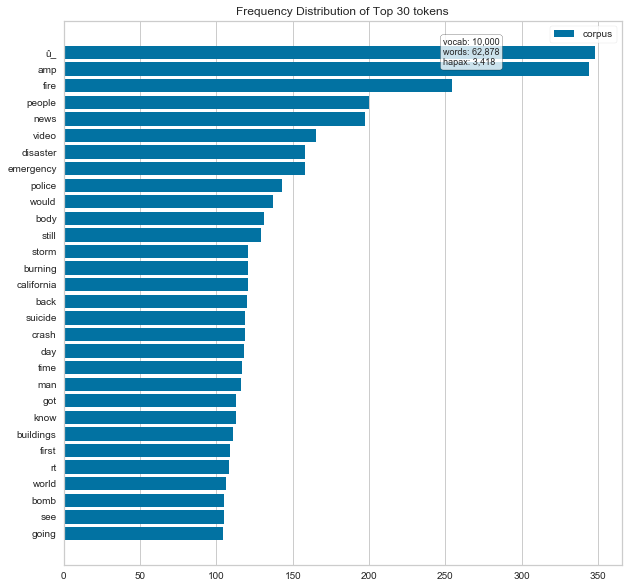

In [77]:
# Find the document term frequency matrix
stopwords = nltk.corpus.stopwords.words('english')

# add some more stop words
newStopWords = ['http','https', 'co', 'via', 'us','like','one','get','new']
stopwords.extend(newStopWords)

vectorizer = CountVectorizer(max_features=10000,
                             analyzer='word',
                             max_df=.6,
                             stop_words=stopwords)

X = vectorizer.fit_transform(df_train['text'])

# Get all features (tokens)
features = vectorizer.get_feature_names()

# we can use yellowbrick package for visualization of top 30 tokens
fig, ax = plt.subplots(figsize=(10, 10))
visualizer = FreqDistVisualizer(features=features, n=30, orient='h')
visualizer.fit(X)
visualizer.poof()

In [78]:
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()

X = tfidfconverter.fit_transform(X).toarray()
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

### Creating the model

In [79]:
rfc = RandomForestClassifier(n_estimators=800, 
                             random_state=42, 
                             max_features='auto')

rfc.fit(X_train, y_train)

# predict for testing data
y_pred_test = rfc.predict(X_test)

# predict for training data
y_pred_train = rfc.predict(X_train)

In [80]:
# test
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

0.792907180385289
[[1179  159]
 [ 314  632]]
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1338
           1       0.80      0.67      0.73       946

   micro avg       0.79      0.79      0.79      2284
   macro avg       0.79      0.77      0.78      2284
weighted avg       0.79      0.79      0.79      2284



In [81]:
# train
print(accuracy_score(y_train, y_pred_train))
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))

0.9919309438919122
[[2993   11]
 [  32 2293]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3004
           1       1.00      0.99      0.99      2325

   micro avg       0.99      0.99      0.99      5329
   macro avg       0.99      0.99      0.99      5329
weighted avg       0.99      0.99      0.99      5329



### Save the Model

In [82]:
#The wb indicates that the file is opened for writing in binary mode
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(rfc,picklefile)

### Load the Model

In [83]:
#The rb indicates that the file is opened for reading in binary mode
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

### Make prediction based on the Loaded model

In [84]:
y_pred_test_2 = model.predict(X_test)

print(confusion_matrix(y_test, y_pred_test_2))
print(classification_report(y_test, y_pred_test_2))
print(accuracy_score(y_test, y_pred_test_2)) 

[[1179  159]
 [ 314  632]]
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1338
           1       0.80      0.67      0.73       946

   micro avg       0.79      0.79      0.79      2284
   macro avg       0.79      0.77      0.78      2284
weighted avg       0.79      0.79      0.79      2284

0.792907180385289
